In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime as dt

ModuleNotFoundError: No module named 'pandas'

In [2]:
# Download the Data
df_ = pd.read_excel("./retail.xlsx", engine='openpyxl')
df = df_.copy()

In [3]:
df.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Based on the missing percentage calculation for each column in the given dataset, the following conclusions can be made:

- `Description`: About 0.27% of the data is missing in the Description column. This is a small percentage and might not have a significant impact on the analysis. 

- `CustomerID`: Approximately 24.93% of the data is missing in the CustomerID column. This is a significant percentage but it won't affect the analysis, as the customer information is not essential for the study. It's possible that purchases can be made as a guest, but in that case, it would be better to assign a specific ID indicating guest transactions for clarity and cleanliness in the data.

In [5]:
# Check for missing values
missing_percentage = df.isnull().sum() / df.shape[0] * 100 
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [6]:
# Remove duplicated entries
print('Dublicated entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Dublicated entries: 5268


In [7]:
# Remove rows with missing CustomerID
# As we want to do customer segmentation, rows without CustomerID are irrelevant.
df.dropna(subset=["CustomerID"], inplace=True)

# Remove column Description
# Description column is irrelevant for customer segmentation.
df.drop(columns=["Description"], inplace=True)

df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Data repair

In [8]:
# Verify that no customerID has a decimal value
df[df["CustomerID"] % 1 != 0]

# Update CustomerID to integer
df["CustomerID"] = df["CustomerID"].astype("int64")

# Update Country to string
df["Country"] = df["Country"].astype(str)


Create new table and Add new attributes

In [9]:
# Create column TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Create customer dataframe
df_customer = pd.DataFrame({'CustomerID': df['CustomerID'].unique()})

# Create new column Total Spent
total_spent_df = df.groupby('CustomerID').agg(TotalSpent=('TotalPrice', 'sum')).reset_index()
df_customer = pd.merge(df_customer, total_spent_df, on='CustomerID')

# Create new column Total Quantity
total_quantity_df = df.groupby('CustomerID').agg(TotalQuantity=('Quantity', 'sum')).reset_index()
df_customer = pd.merge(df_customer, total_quantity_df, on='CustomerID')

# Create new column Average Price
average_price_df = df.groupby('CustomerID').agg(AveragePrice=('UnitPrice', 'mean')).reset_index()
df_customer = pd.merge(df_customer, average_price_df, on='CustomerID')

# Create new column unique products
unique_products_df = df.groupby('CustomerID').agg(UniqueProducts=('StockCode', 'nunique')).reset_index()
df_customer = pd.merge(df_customer, unique_products_df, on='CustomerID')

# Create new column returned products that have a c in the invoice number
returned_products_df = df[df['InvoiceNo'].str.contains('C', na=False)]
returned_products_df = returned_products_df.groupby('CustomerID').agg(ReturnedProducts=('StockCode', 'count')).reset_index()
df_customer = pd.merge(df_customer, returned_products_df, on='CustomerID')



## Customer Segmentation using RFM (Recency, Frequency, Total Spent)


![segmentation.png](attachment:segmentation.png)

In [10]:
df.shape

(401604, 8)

In [11]:
# Check if there null entires left in the data set
df.isnull().sum()

InvoiceNo      0
StockCode      0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [12]:
# Check for Invoinces that contain "C" indicating a cancelled Invoice
df[df["InvoiceNo"].str.contains("C", na=False)]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
141,C536379,D,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50
154,C536383,35004C,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65
235,C536391,22556,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80
236,C536391,21984,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
237,C536391,21983,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
...,...,...,...,...,...,...,...,...
540449,C581490,23144,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,-9.13
541541,C581499,M,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,-224.69
541715,C581568,21258,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,-54.75
541716,C581569,84978,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,-1.25


In [13]:
# Filter out cancelled Invoices
df = df[~df["InvoiceNo"].str.contains("C", na=False)]

<Axes: title={'center': 'Price\n'}>

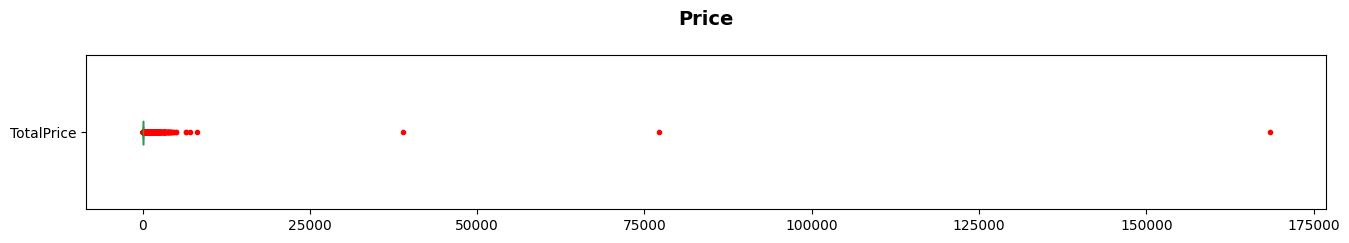

In [14]:
# plot the price distribution box
box_plot = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
price_dist = df['TotalPrice'].plot(kind='box', vert=False, flierprops=box_plot, title = "Total Price", figsize=(16,2));
plt.title('Price\n', fontsize=14, fontweight='bold')
price_dist

In [15]:
df[df['TotalPrice'] > 5000].count()

InvoiceNo      7
StockCode      7
Quantity       7
InvoiceDate    7
UnitPrice      7
CustomerID     7
Country        7
TotalPrice     7
dtype: int64

In [16]:
# Remove all values higher than the threshold of 5000
df = df[df['TotalPrice'] < 5000]

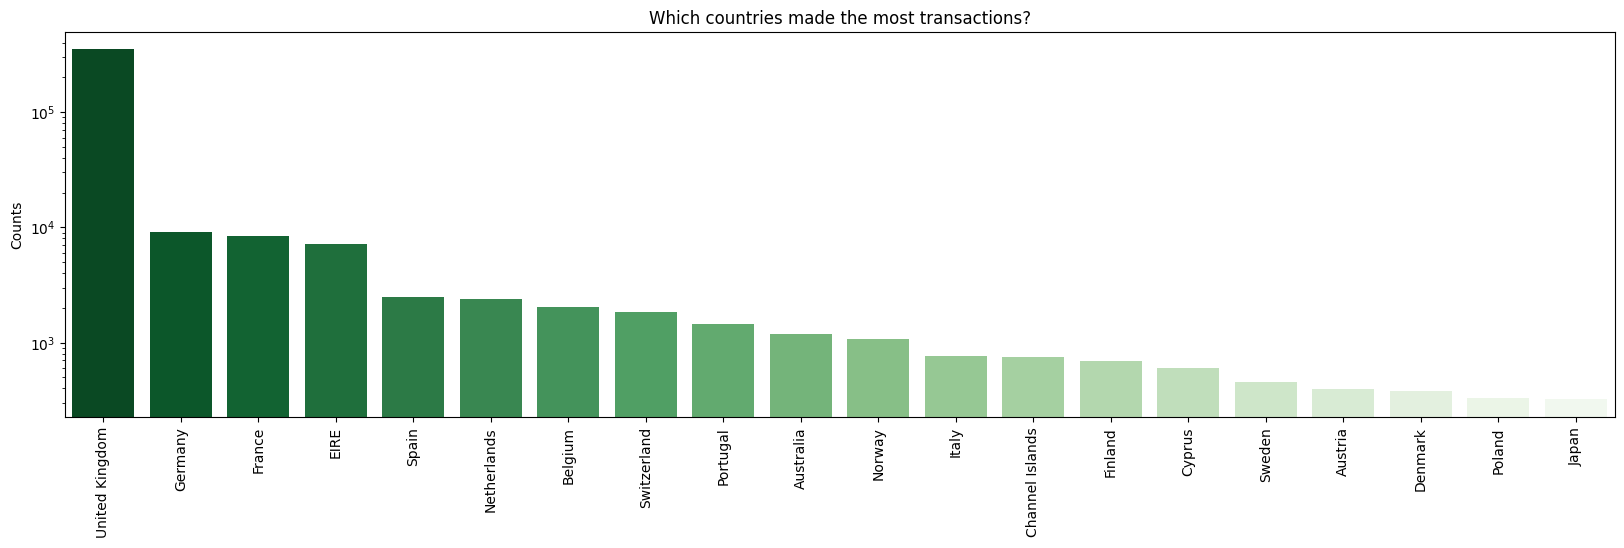

In [17]:
country_counts = df.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

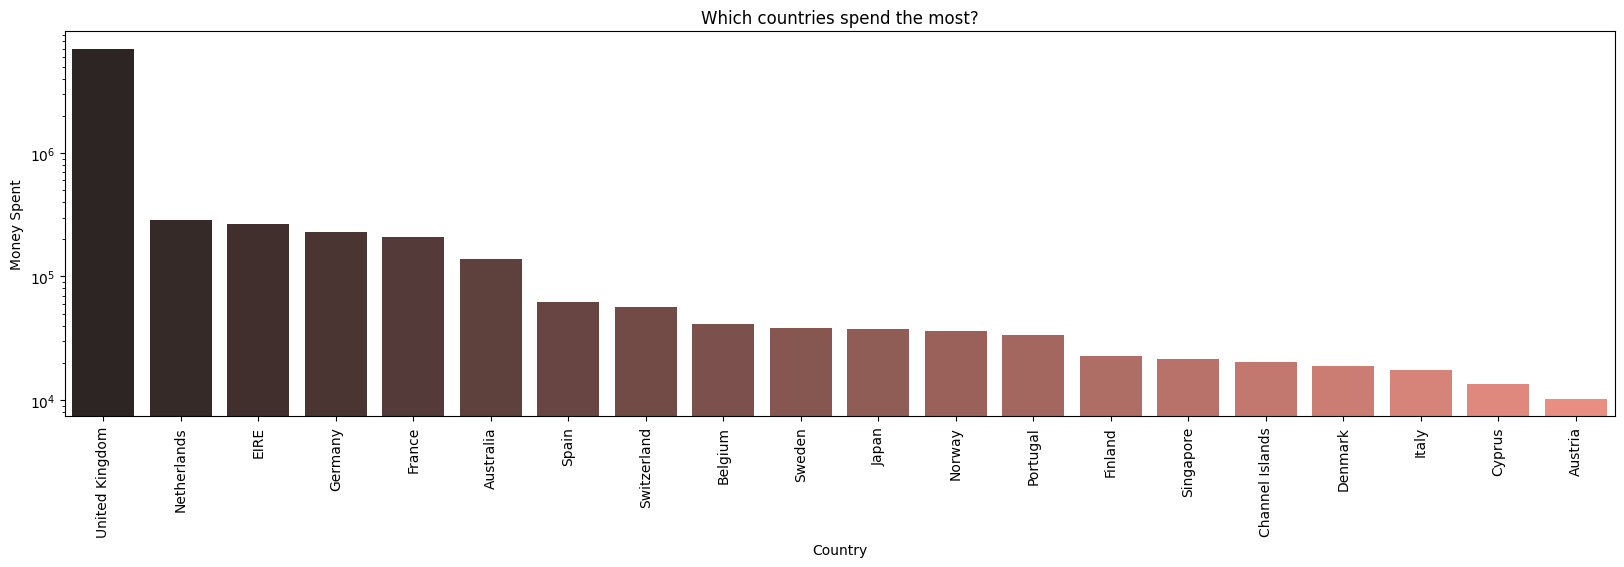

In [18]:
group_country_amount_spent = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=group_country_amount_spent.index, y=group_country_amount_spent.values, palette="dark:salmon")
plt.ylabel("Money Spent")
plt.title("Which countries spend the most?");
plt.xticks(rotation=90);
plt.yscale("log")

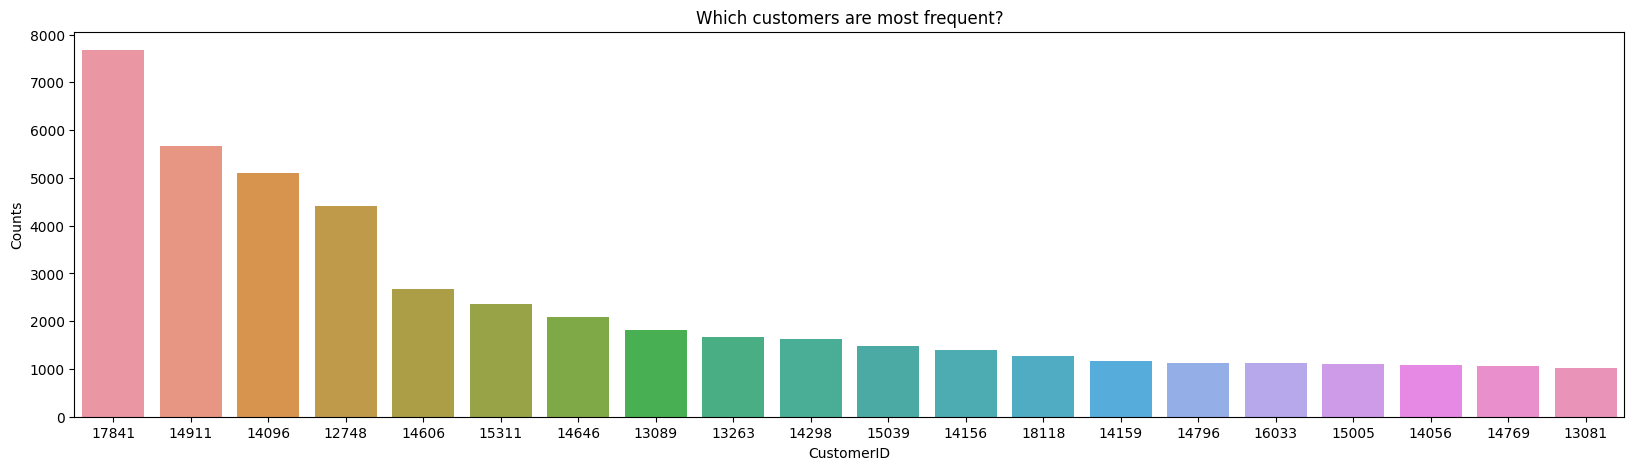

In [19]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(x=customer_counts.index, y=customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most frequent?");
#plt.xticks(rotation=90);

Text(0.5, 1.0, 'Sales by Months ')

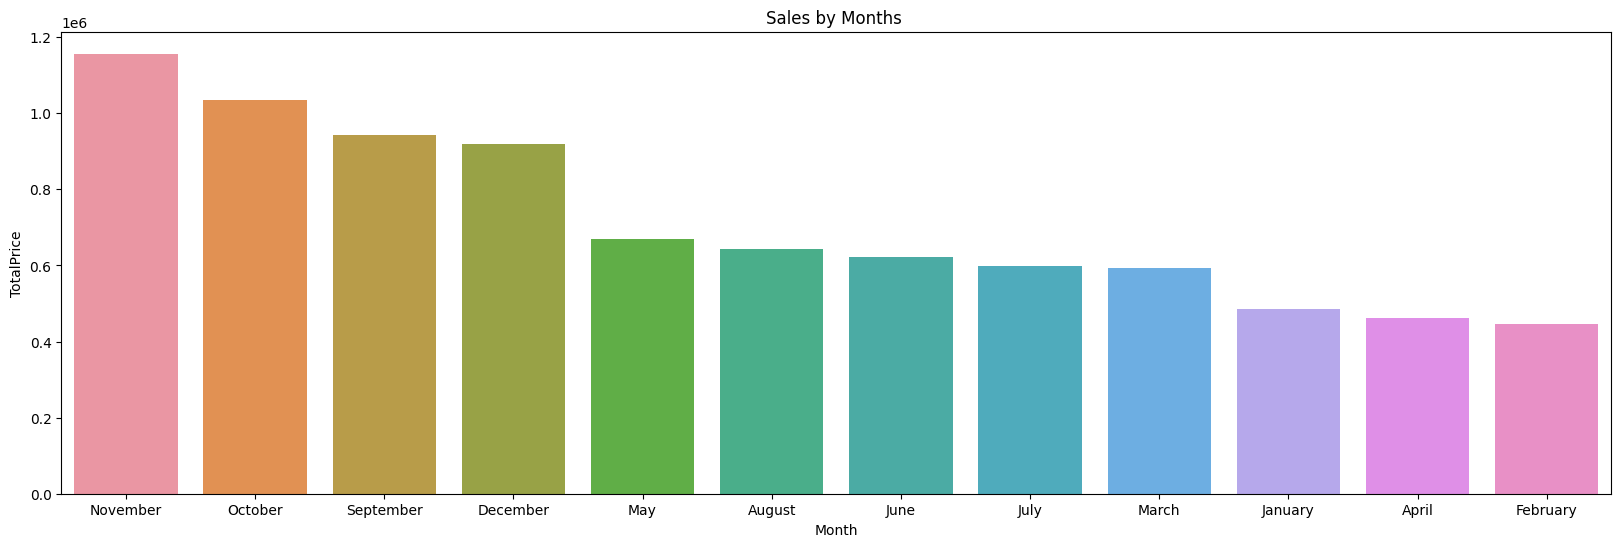

In [20]:
# Sales different months.
# extracting month from the Invoice date
df['Month']=df['InvoiceDate'].dt.month_name()
SalesbyMonth=df.groupby('Month')['TotalPrice'].sum().reset_index().sort_values('TotalPrice',ascending=False)
plt.figure(figsize=(20,6))
sns.barplot(x=SalesbyMonth['Month'],y=SalesbyMonth['TotalPrice'])
plt.title('Sales by Months ')

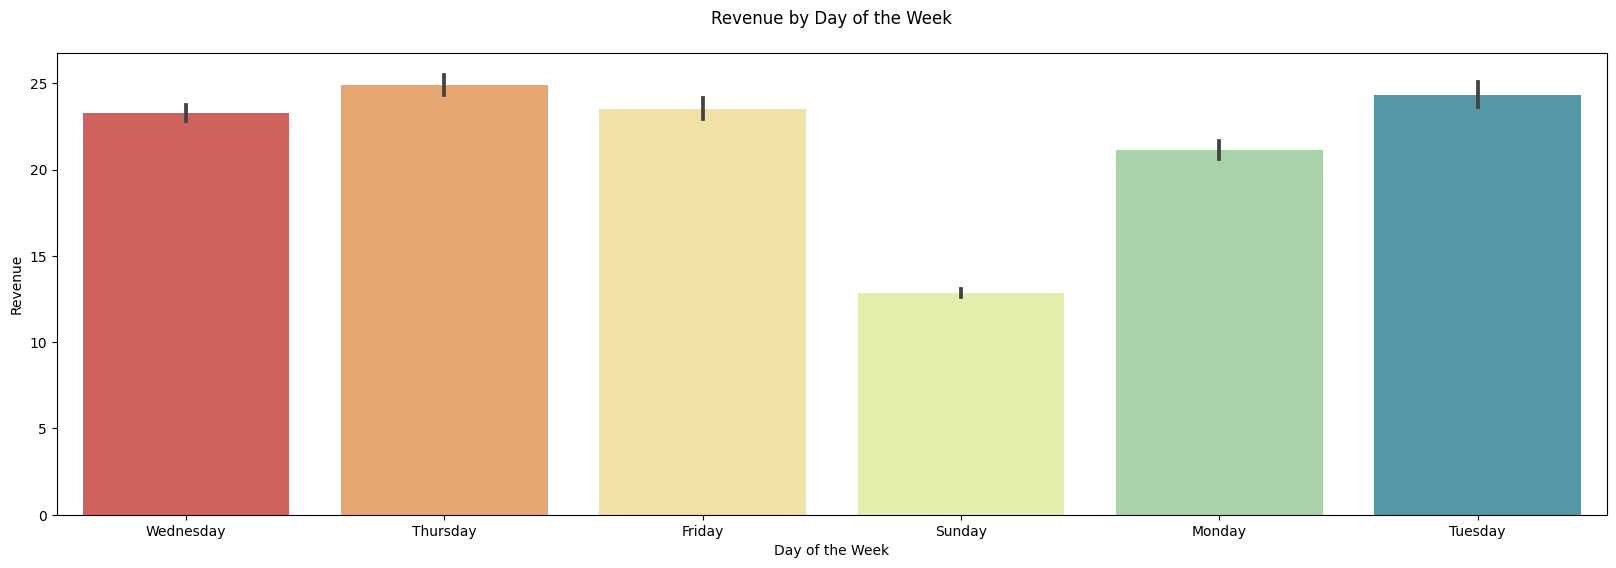

In [21]:
# extracting day from the Invoice date
df['Day']=df['InvoiceDate'].dt.day_name()
# plot revenue by day of the week
plt.figure(figsize=(20,6))
plt.title('Revenue by Day of the Week\n')
sns.barplot(x=df['Day'], y=df['TotalPrice'], palette="Spectral")
plt.xlabel('Day of the Week')
plt.ylabel('Revenue')
plt.show()


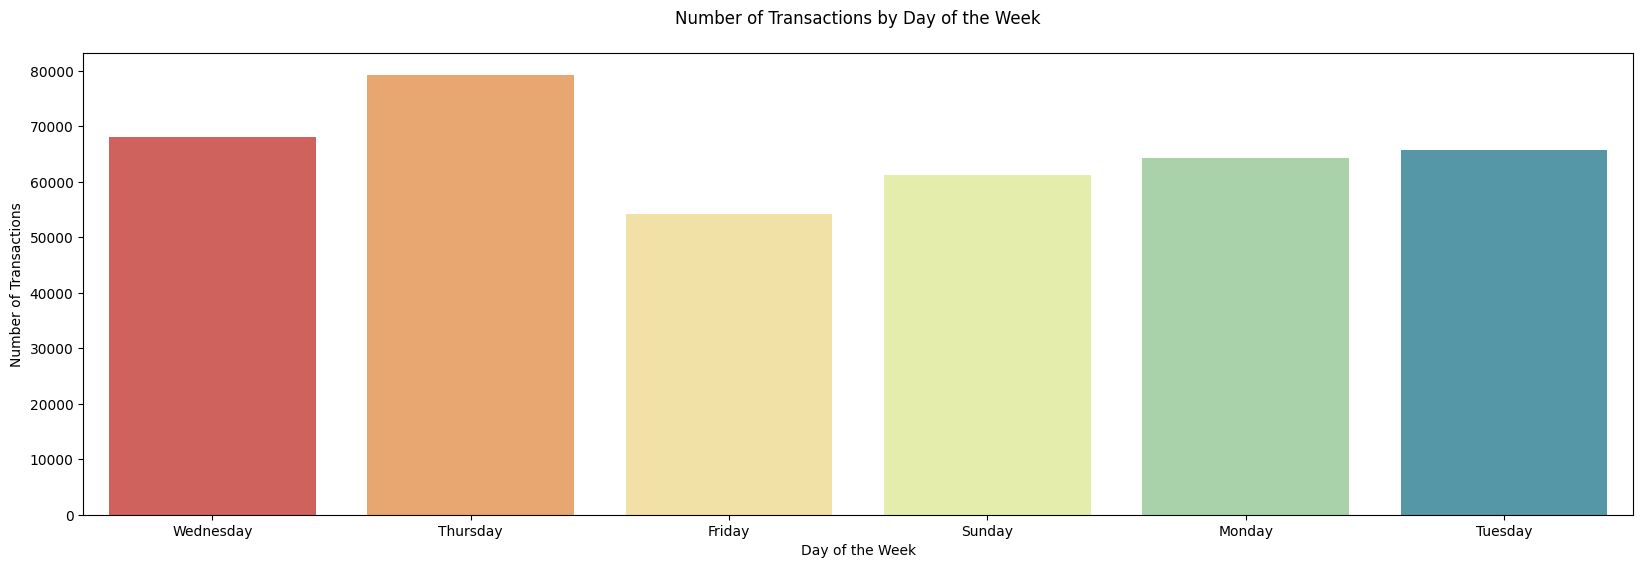

In [22]:
# plot number of transactions by day of the week
plt.figure(figsize=(20,6))
plt.title('Number of Transactions by Day of the Week\n')
sns.countplot(x=df['Day'], palette="Spectral")
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.show()

<Figure size 2000x1000 with 0 Axes>

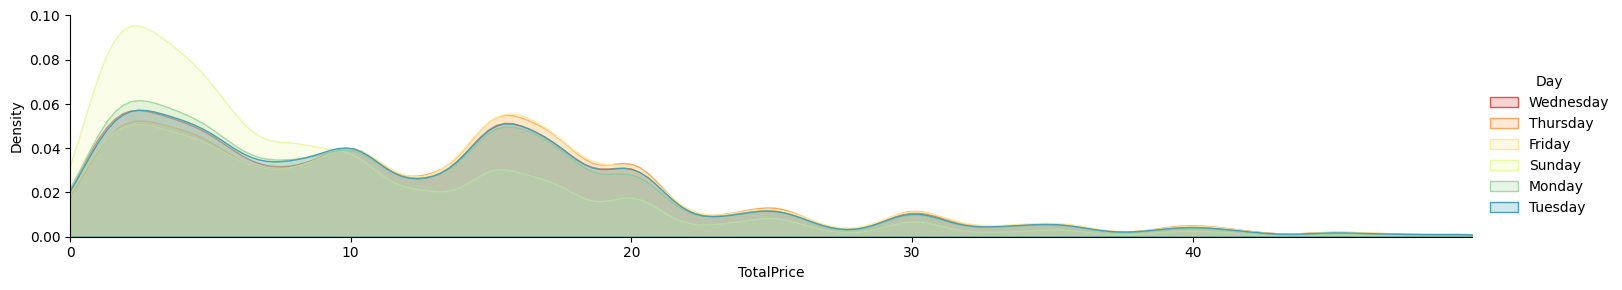

In [23]:
with sns.color_palette('Spectral'):
    plt.figure(figsize=(20,10))
    facet = sns.FacetGrid(df[df['TotalPrice'] < 50], hue="Day", aspect=5)
    facet.map(sns.kdeplot, 'TotalPrice', fill=True)
    facet.set(xlim=(0, df[df['TotalPrice'] < 50]['TotalPrice'].max().item()))
    facet.add_legend()

In [24]:
# Find max InvoiceDate
df["InvoiceDate"].max()

# Starting Date for RFM Analysis
first_analysis_date = df["InvoiceDate"].min()

# Group Data by CustomerID
# Calculate days between first analysis date and last invoice date
# Count unique invoices
# Get Total Price for each customer
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda date: (first_analysis_date - date.max()).days,
                                     'InvoiceNo': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [25]:
rfm

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12347,-372,7,4310.00
12348,-299,4,1797.24
12349,-356,1,1757.55
12350,-64,1,334.40
12352,-338,8,2506.04
...,...,...,...
18280,-97,1,180.60
18281,-194,1,80.82
18282,-367,2,178.05


In [26]:
# Rename InvoiceDate, InvoiceNo, TotalPrice to recency, frequency, total_spent
rfm.columns = ['recency', 'frequency', 'total_spent']

In [27]:
# Return descriptive statistics of the dataframe and transpose.
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,-281.952974,99.961812,-374.0,-357.00,-324.00,-232.2500,-1.00
frequency,4338.0,4.272015,7.704614,1.0,1.00,2.00,5.0000,210.00
total_spent,4338.0,1976.537442,8461.295778,0.0,306.21,668.04,1653.7775,280206.02


In [28]:
# Filter the rfm dataframe to only include rows where "total_spent" > 0 (Only customers who had a positive monetary impact)
rfm = rfm[rfm["total_spent"] > 0]

In [29]:
# Return descriptive statistics of the dataframe and transpose.
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4337.0,-281.934978,99.966311,-374.0,-357.00,-324.00,-232.00,-1.00
frequency,4337.0,4.272769,7.705343,1.0,1.00,2.00,5.00,210.00
total_spent,4337.0,1976.993181,8462.218176,2.9,306.45,668.43,1654.31,280206.02


In [30]:
# Create scores based on RFM metrics

# Recenency score is inverted, because lower recency (negative numbers) -> better
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])


# Frequency score - Higher = Better
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Total Spent score - Higher = Better
rfm["total_spent_score"] = pd.qcut(rfm['total_spent'], 5, labels=[1,2,3,4,5])

<ipython-input-30-3e87cc4f2e63>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
<ipython-input-30-3e87cc4f2e63>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
<ipython-input-30-3e87cc4f2e63>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [31]:
# Create two-digit RFM_Score (not considering total_spent value)
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                   rfm['frequency_score'].astype(str))

<ipython-input-31-13dcfb81560f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +


In [32]:
# Segment customers based on their RFM_SCORE.
seg_map = {
    r'[1-2][1-2]': 'inactive_customers',
    r'[1-2][3-4]': 'high_risk',
    r'[1-2]5': 'recoverable_customers',
    r'3[1-2]': 'slipping_away',
    r'33': 'require_attention',
    r'[3-4][4-5]': 'steady_supporters',
    r'41': 'recently_onboarded',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'loyalty_potential',
    r'5[4-5]': 'brand_ambassadors'
}

In [33]:
# Each RFM_Score value is matched against the keys in seg_map. When a match is found, the RFM_SCORE value is replaced
# by the value found in seg_map. This classifies each customer into one of the segments in seg_map
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

<ipython-input-33-b534fb95aebb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)


In [34]:
rfm.head()

,recency,frequency,total_spent,recency_score,frequency_score,total_spent_score,RFM_SCORE,segment
CustomerID,,,,,,,,
12347,-372,7,4310.00,5,5,5,55,brand_ambassadors
12348,-299,4,1797.24,2,4,4,24,high_risk
12349,-356,1,1757.55,4,1,4,41,recently_onboarded
12350,-64,1,334.40,1,1,2,11,inactive_customers
12352,-338,8,2506.04,3,5,5,35,steady_supporters


In [35]:
# Group by Segment to see how many customers fall into each category.
# Also compute the mean of "recency", "frequency" and "total_spent"
rfm[["segment", "recency", "frequency", "total_spent"]].groupby("segment").agg(["mean", "count"])

recency        frequency        total_spent      
                             mean count       mean count         mean count
segment                                                                    
brand_ambassadors     -368.340458   655  12.279389   655  6703.140061   655
high_risk             -221.205734   593   2.876897   593   993.148366   593
inactive_customers    -157.493931  1071   1.101774  1071   415.564764  1071
loyalty_potential     -357.570539   482   2.012448   482   690.830021   482
new_customers         -366.702128    47   1.000000    47   367.003191    47
recently_onboarded    -350.977778    90   1.000000    90   295.330667    90
recoverable_customers -242.031746    63   8.380952    63  2790.101429    63
require_attention     -322.561497   187   2.326203   187   892.505936   187
slipping_away         -321.678977   352   1.161932   352   469.893437   352
steady_supporters     -340.863237   797   6.427854   797  2841.617780   797

In [36]:
# Find customers that fall into the category "need_attention"
rfm[rfm["segment"] == "require_attention"].head()

,recency,frequency,total_spent,recency_score,frequency_score,total_spent_score,RFM_SCORE,segment
CustomerID,,,,,,,,
12360,-322,3,2662.06,3,3,5,33,require_attention
12372,-303,3,1298.04,3,3,4,33,require_attention
12413,-308,3,758.10,3,3,3,33,require_attention
12456,-330,3,3181.04,3,3,5,33,require_attention
12536,-331,3,12601.83,3,3,5,33,require_attention


In [37]:
# Create new dataframe that only considers the customers that fall into the segment "require_attention"
new_df = pd.DataFrame()
new_df["new_customer_id"] = rfm[rfm["segment"] == "require_attention"].index
new_df.head()

,new_customer_id
0,12360
1,12372
2,12413
3,12456
4,12536


In [38]:
rfm.head()

,recency,frequency,total_spent,recency_score,frequency_score,total_spent_score,RFM_SCORE,segment
CustomerID,,,,,,,,
12347,-372,7,4310.00,5,5,5,55,brand_ambassadors
12348,-299,4,1797.24,2,4,4,24,high_risk
12349,-356,1,1757.55,4,1,4,41,recently_onboarded
12350,-64,1,334.40,1,1,2,11,inactive_customers
12352,-338,8,2506.04,3,5,5,35,steady_supporters


Visualization

In [39]:
# Merge df_customer and rfm on CustomerID in a new dataframe called df_customer_rfm
df_customer_rfm = pd.merge(df_customer, rfm, left_on="CustomerID", right_on="CustomerID")
segmented_df = df_customer_rfm.groupby('segment')
custom_order = ['inactive_customer', 'high_risk', 'recoverable_customers', 'slipping_away',
                'require_attention', 'steady_supporters', 'recently_onboarded',
                'new_customers', 'loyalty_potential', 'brand_ambassadors']


In [41]:
average_price

segment
inactive_customer              NaN
high_risk                45.608833
recoverable_customers     4.620203
slipping_away             6.098503
require_attention         4.436304
steady_supporters         4.563556
recently_onboarded        2.880484
new_customers             1.808346
loyalty_potential         3.808375
brand_ambassadors         3.332444
Name: AveragePrice, dtype: float64

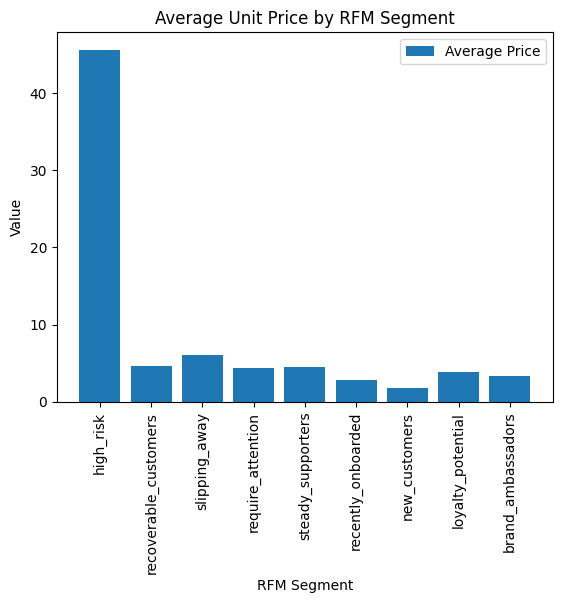

In [40]:
#  AVERAGE UNIT PRICE BY RFM SEGMENT
average_price = segmented_df['AveragePrice'].mean()
average_price = average_price.reindex(custom_order)
fig, ax = plt.subplots()

ax.bar(average_price.index, average_price.values, label='Average Price')

# Set the labels and title
ax.set_xlabel('RFM Segment')
ax.set_ylabel('Value')
ax.set_title('Average Unit Price by RFM Segment')
ax.legend()
plt.xticks(rotation=90)
plt.show()


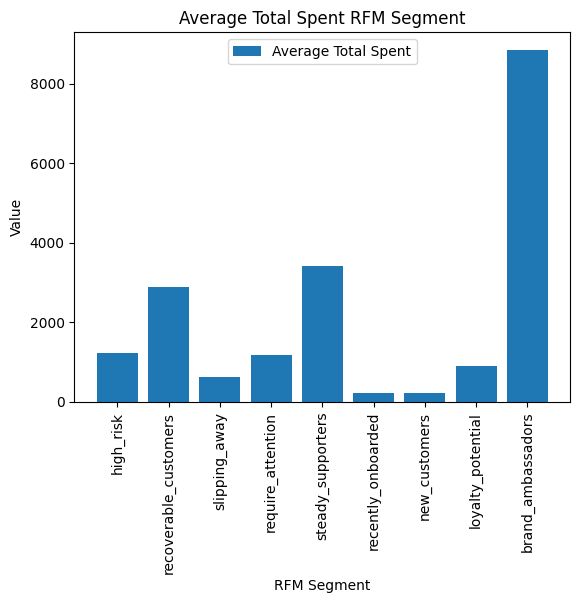

In [42]:
#  AVERAGE TOTAL SPENT BY RFM SEGMENT
average_total_spent = segmented_df['TotalSpent'].mean()
average_total_spent = average_total_spent.reindex(custom_order)
fig, ax = plt.subplots()
ax.bar(average_total_spent.index, average_total_spent.values, label='Average Total Spent')

# Set the labels and title
ax.set_xlabel('RFM Segment')
ax.set_ylabel('Value')
ax.set_title('Average Total Spent RFM Segment')
ax.legend()
plt.xticks(rotation=90)
plt.show()


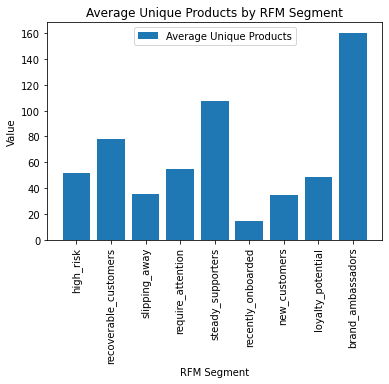

In [ ]:
#  AVERAGE NUMBER OF UNIQUE PRODUCTS BY RFM SEGMENT
num_unique_products = segmented_df['UniqueProducts'].mean()
num_unique_products = num_unique_products.reindex(custom_order)
fig, ax = plt.subplots()
ax.bar(num_unique_products.index, num_unique_products.values, label='Average Unique Products')

# Set the labels and title
ax.set_xlabel('RFM Segment')
ax.set_ylabel('Value')
ax.set_title('Average Unique Products by RFM Segment')
ax.legend()
plt.xticks(rotation=90)
plt.show()


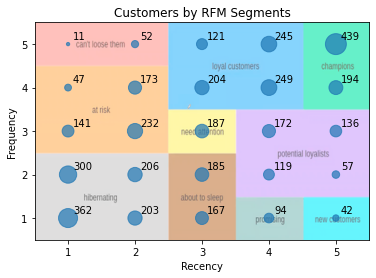

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming your customer dataframe is named 'customer_df'
# and the RFM score is stored in the 'RFM_SCORE' column

# Group customers by RFM score
grouped_df = rfm.groupby('RFM_SCORE')
customer_counts = grouped_df.size()

# Create a 2D map with x and y axes representing the RFM score ranges (1 to 5)
x = [int(score[0]) for score in customer_counts.index]
y = [int(score[1]) for score in customer_counts.index]
x_shifted = [coord + 0.5 for coord in x]
y_shifted = [coord + 0.5 for coord in y]

# Plot the scatter points on the map
plt.scatter(x_shifted, y_shifted, s=customer_counts.values, alpha=0.7)

# Add labels for each point indicating the number of customers in that segment
for i, count in enumerate(customer_counts.values):
    plt.annotate(str(count), (x_shifted[i], y_shifted[i]), xytext=(5, 5), textcoords='offset points')

img = mpimg.imread('./map_cropped.png')
plt.imshow(img, extent=[1, 6, 1, 6], aspect='auto', alpha=0.6)

# Set the shifted x and y axis tick positions and labels
plt.xticks([i + 0.5 for i in range(1, 6)], range(1, 6))
plt.yticks([i + 0.5 for i in range(1, 6)], range(1, 6))

# Set the x and y axis labels
plt.xlabel('Recency')
plt.ylabel('Frequency')

# Set the plot title
plt.title('Customers by RFM Segments')

# Display the plot
plt.show()


## Customer Segmentation using RFM (Recency, Frequency, Monetary) THIS PART IS INCOMPLETE 

In [ ]:
new_df = df_.copy()

new_df[new_df["InvoiceNo"].str.contains("C", na=False)]

new_df = new_df[~new_df["InvoiceNo"].str.contains("C", na=False)]

# Find max InvoiceDate
new_df["InvoiceDate"].max()

# Starting Date for RFM Analysis
first_analysis_date = new_df["InvoiceDate"].min()

# Create column TotalPrice
new_df["TotalPrice"] = new_df["Quantity"] * new_df["UnitPrice"]

# Group Data by CustomerID
# Calculate days between first analysis date and last invoice date
# Count unique invoices
# Get Total Price for each customer
new_rfm = new_df.groupby('CustomerID').agg({'InvoiceDate': lambda date: (first_analysis_date - date.max()).days,
                                     'InvoiceNo': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
new_rfm

In [ ]:
# Rename InvoiceDate, InvoiceNo, TotalPrice to recency, frequency, monetary
new_rfm.columns = ['recency', 'frequency', 'monetary']
new_rfm = new_rfm[new_rfm["monetary"] > 0]

# Create scores based on RFM metrics

# Recenency score is inverted, because lower recency (negative numbers) -> better
new_rfm["recency_score"] = pd.qcut(new_rfm['recency'], 5, labels=[5,4,3,2,1])

# Frequency score - Higher = Better
new_rfm["frequency_score"] = pd.qcut(new_rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Total Spent score - Higher = Better
new_rfm["monetary_score"] = pd.qcut(new_rfm['monetary'], 5, labels=[1,2,3,4,5])

# Create two-digit RFM_Score (not considering total_spent value)
new_rfm["RFM_SCORE"] = (new_rfm['recency_score'].astype(str) +
                   new_rfm['frequency_score'].astype(str) +
                   new_rfm['monetary_score'].astype(str))


new_seg_map = {
    r'[1-2]1[1-2]': 'low_frequency_low_monetary',
    r'[1-2]1[3-5]': 'low_frequency_high_monetary',
    r'[3-5]1[1-2]': 'high_frequency_low_monetary',
    r'[3-5]1[3-5]': 'high_frequency_high_monetary',
    r'[1-2]2[1-2]': 'low_frequency_low_monetary',
    r'[1-2]2[3-5]': 'low_frequency_high_monetary',
    r'[3-5]2[1-2]': 'high_frequency_low_monetary',
    r'[3-5]2[3-5]': 'high_frequency_high_monetary',
    r'[1-2]3[1-2]': 'low_frequency_low_monetary',
    r'[1-2]3[3-5]': 'low_frequency_high_monetary',
    r'[3-5]3[1-2]': 'high_frequency_low_monetary',
    r'[3-5]3[3-5]': 'high_frequency_high_monetary',
    r'[1-2]4[1-2]': 'low_frequency_low_monetary',
    r'[1-2]4[3-5]': 'low_frequency_high_monetary',
    r'[3-5]4[1-2]': 'high_frequency_low_monetary',
    r'[3-5]4[3-5]': 'high_frequency_high_monetary',
    r'[1-2]5[1-2]': 'low_frequency_low_monetary',
    r'[1-2]5[3-5]': 'low_frequency_high_monetary',
    r'[3-5]5[1-2]': 'high_frequency_low_monetary',
    r'[3-5]5[3-5]': 'high_frequency_high_monetary',
}

# Each RFM_Score value is matched against the keys in seg_map. When a match is found, the RFM_SCORE value is replaced
# by the value found in seg_map. This classifies each customer into one of the segments in seg_map
new_rfm['segment'] = new_rfm['RFM_SCORE'].replace(new_seg_map, regex=True)

new_rfm.head()

In [ ]:
# Find customers that fall into the category "brand_ambassadors_high_monetary"
new_rfm[new_rfm["segment"] == "brand_ambassadors_high_monetary"].head()